```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```


# Forward Simulation of Magnetic Gradiometry Data for Magnetic Vector Models on a Tree Mesh

</br>

**Author:** Devin C. Cowan

</br>

**Keywords:** gradiometry, magnetic vector model, forward simulation, integral formulation, tree mesh.

</br>

**Summary:** Here we use the module [SimPEG.potential_fields.magnetics](myst:SimPEG#SimPEG.potential_fields.magnetics) to simulate magnetic gradiometry data for a magnetic vector model. We use the integral solution and carry out the forward simulation on a tree mesh. For this tutorial, we focus on the following:

- How to create magnetic gradiometry surveys
- How to design a tree mesh for magnetic simulations (integral solution)
- How to construct a magnetic vector model
- How to predict magnetic gradiometry data for a magnetic vector model
- How to include surface topography
- The units of the magnetic vector model and resulting data

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to simulating magnetic data are imported from [SimPEG.potential_fields.magnetics](myst:SimPEG#SimPEG.potential_fields.magnetics).
We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils). To simulate gravity data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from SimPEG.potential_fields import magnetics
from SimPEG.utils import plot2Ddata, model_builder, mat_utils
from SimPEG import maps

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
import os

save_output = False  # Optional

## Defining Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray) for 3D simulations.
Here, we create basic topography for the forward simulation.
For user-specific simulations, you may load topography from an XYZ file.

In [2]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

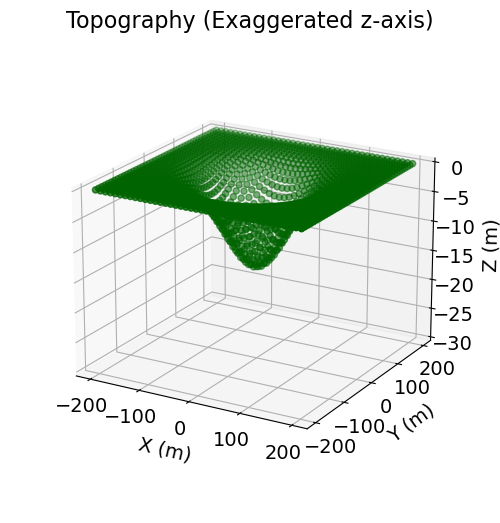

In [3]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='3d')
ax.set_zlim([-30, 0])
ax.scatter3D(x_topo, y_topo, z_topo, c='darkgreen')
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel('X (m)', labelpad=10)
ax.set_ylabel('Y (m)', labelpad=10)
ax.set_zlabel('Z (m)', labelpad=10)
ax.set_title('Topography (Exaggerated z-axis)', fontsize=16, pad=-20)
ax.view_init(elev=20.)

## Defining the Survey

Surveys within SimPEG generally require the user to create and connect three types of objects:

- [receivers](myst:SimPEG#SimPEG.potential_fields.magnetics.receivers.Point): which define the locations of field measurements and type of data being measured.
- [sources](myst:SimPEG#SimPEG.potential_fields.magnetics.sources.UniformBackgroundField): the passive or active sources responsible for generating geophysical responses, and their associated receivers.
- [survey](myst:SimPEG#SimPEG.potential_fields.magnetics.survey.Survey): the object which stores and organizes all of the sources and receivers.

Here, we define the survey that will be used for the forward simulation. Magnetic surveys are simple to create. The user only needs an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray) to define the xyz locations of the observation locations, the field components being measured, and the Earth's inducing field. For the tutorial simulation, the receivers are located 10 m above the surface topography and spaced 10 m apart.

In [4]:
# Define the observation locations as an (N, 3) numpy array or load them.
x = np.linspace(-80.0, 80.0, 17)
y = np.linspace(-80.0, 80.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 10  # Flight height 10 m above surface.
receiver_locations = np.c_[x, y, z]

In [5]:
# Define the component(s) of the field we want to simulate as strings within
# a list. Here we measure the x, y and z derivatives of the Bz anomaly at
# each observation location.
components = ["bxz", "byz", "bzz"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
field_inclination = 45
field_declination = 30
field_strength = 50000
inducing_field = (field_strength, field_inclination, field_declination)

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

If desired, we can extract various objects and properties from the objects used to generate the survey. E.g.

In [6]:
print('# of locations: {}'.format(survey.nRx))  # number of receiver locations
print('# of data: {}'.format(survey.nD))        # number of data that will be simulated
print(survey.source_field.inclination)          # inclination of the source field
print(survey.source_field.receiver_list[0])     # the receiver object
print(receiver_list[0].locations[:5, :])        # the first 5 receiver locations

# of locations: 289
# of data: 867
90.0
[[-80.         -80.           7.96997075]
 [-70.         -80.           7.43380258]
 [-60.         -80.           6.85582919]
 [-50.         -80.           6.26620478]
 [-40.         -80.           5.70242805]]


## Designing a (Tree) Mesh

Meshes are designed using the [discretize](https://discretize.simpeg.xyz/en/main) package. See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes.
Here, the forward simulation is computed for a [tree mesh](myst:discretize#discretize.TreeMesh). If you wanted to generate a [tensor mesh](myst:discretize#discretize.TensorMesh) instead, you can use the code snippet from the [Forward simulation of gravity anomaly data on a tensor mesh](fwd_gravity_anomaly_3d.ipynb) tutorial.

The integral formulation for gravity essentially sums the independent gravity anomaly contribution for every voxel cell in the mesh. Since the kernel function that computes the contribution for a single cell is an analytic solution, small cells are not required to accurately compute the contributions from coarse structures with constant density (e.g. a rectangular prism). For complex structures however, or to define surface topography more accurately, finer cells may be needed. Furthermore, cells do not need to be cubic.

Here, a minimum cell width of 5 m is used within our survey region. In this tutorial, we discretize finely along the surface topography, and within our region of interest. However, a multitude of refinement methods can be applied when generating tree meshes.

In [7]:
dx = 5  # minimum cell width (base mesh cell width) in x
dy = 5  # minimum cell width (base mesh cell width) in y
dz = 5  # minimum cell width (base mesh cell width) in z

x_length = 240.0  # domain width in x
y_length = 240.0  # domain width in y
z_length = 120.0  # domain width in z

# Compute number of base mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Refine based on surface topography
mesh.refine_surface(
    topo_xyz, padding_cells_by_level=[2, 2], finalize=False
)

# Refine box based on region of interest
wsb_corner = np.c_[-100, -100, -80]
ent_corner = np.c_[100, 100, 0]
# Note -1 is a flag for smallest cell size
mesh.refine_box(wsb_corner, ent_corner, levels=[-1], finalize=False)

mesh.finalize()

If desired, we can extract various properties of the mesh. E.g.

In [8]:
print('# of cells: {}'.format(mesh.n_cells))                  # Number of cells
print('# of x-faces: {}'.format(mesh.n_faces_x))              # Number of x-faces
print('Origin: {}'.format(mesh.origin))                       # bottom-southewest corner
print('Max cell volume: {}'.format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])                              # Cell center locations

# of cells: 38784
# of x-faces: 38672
Origin: [-160. -160. -160.]
Max cell volume: 64000.0
[[-140. -140. -140.]
 [-100. -140. -140.]
 [-140. -100. -140.]
 [-100. -100. -140.]
 [-140. -140. -100.]]


## Active Cells and Mapping from the Model to Active Cells

Whereas cells below the Earth's surface contribute towards the simulated gravity anomaly, air cells do not. 
The set of mesh cells used in the forward simulation are referred to as 'active cells'. Unused cells (air cells) are 'inactive cells'. Here, the discretize [active_from_xyz](myst:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [9]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
ind_active = active_from_xyz(mesh, topo_xyz)

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For example, the model may be defined as the logarithms of the physical property values, or be parameters defining a layered Earth. When simulating magnetic data using the integral formulation, we must define a mapping from the set of model parameters to the active cells in the mesh. Mappings are created using the [SimPEG.maps](myst:SimPEG#SimPEG.maps.IdentityMap) module. For the tutorial exercise, the model is the density contrast values for all active cells. As such, our mapping is an identity mapping, whose dimensions are equal to the number of active cells.

In [10]:
# Define mapping from model to active cells. The model consists of a density
# contrast value for each cell below the Earth's surface.
n_active = int(ind_active.sum())
model_map = maps.IdentityMap(nP=3*n_active)

## Define the Magnetic Vector Model

Magnetic vector models are defined by three-component effective
susceptibilities. To create a magnetic vector
model, we must

1) Multiply the magnetic susceptibility for each cell by the unit vector direction of the inducing field.
2) Define the remanent magnetization vector for each cell, then normalize by the magnitude of the Earth's field.
3) Sum the induced and remanent contributions obtained from steps 1 and 2
4) Re-organize the quantity as a 1D [numpy.ndarray](myst:numpy#numpy.ndarray) organized by vector component; i.e. np.r_[chi_1, chi_2, chi_3]

In SimPEG, the magnetic vector model represents the total magnetization normalized by the inducing field. As a result, **magnetic vector models in SimPEG represent an effective susceptibility and are defined using SI units**. Here, 

Here, the model consists of a susceptible and remanently magnetized sphere within a negligibly susceptible host. The horizontal component of the induced and remanent magnetization has been balance so that they cancel out, and the net magnetization is downward. We plot the magnetic vector models using the [plot_slice](myst:discretize#discretize.TreeMesh.plot_slice) method.

In [11]:
# Define susceptibility values for each unit in SI
background_susceptibility = 0.0001
sphere_susceptibility = 0.01

In [12]:
# Define susceptibility for each cell
susceptibility_model = background_susceptibility * np.ones(n_active)
ind_sphere = model_builder.get_indices_sphere(np.r_[0.0, 0.0, -45.0], 15.0, mesh.gridCC)
ind_sphere = ind_sphere[ind_active]
susceptibility_model[ind_sphere] = sphere_susceptibility

# Compute the unit direction of the inducing field in Cartesian coordinates
field_direction = mat_utils.dip_azimuth2cartesian(field_inclination, field_declination)

# Multiply susceptibility model to obtain the x, y, z components of the
# effective susceptibility contribution from induced magnetization.
susceptibility_model = np.outer(susceptibility_model, field_direction)

In [13]:
# Define the effective susceptibility contribution for remanent magnetization to have a
# magnitude of 0.006 SI, with inclination -45 and declination 90
remanence_inclination = 45.0
remanence_declination = -30.0
remanence_susceptibility = 0.01

remanence_model = np.zeros(np.shape(susceptibility_model))
effective_susceptibility_sphere = (
    remanence_susceptibility
    * mat_utils.dip_azimuth2cartesian(remanence_inclination, remanence_declination)
)
remanence_model[ind_sphere, :] = effective_susceptibility_sphere

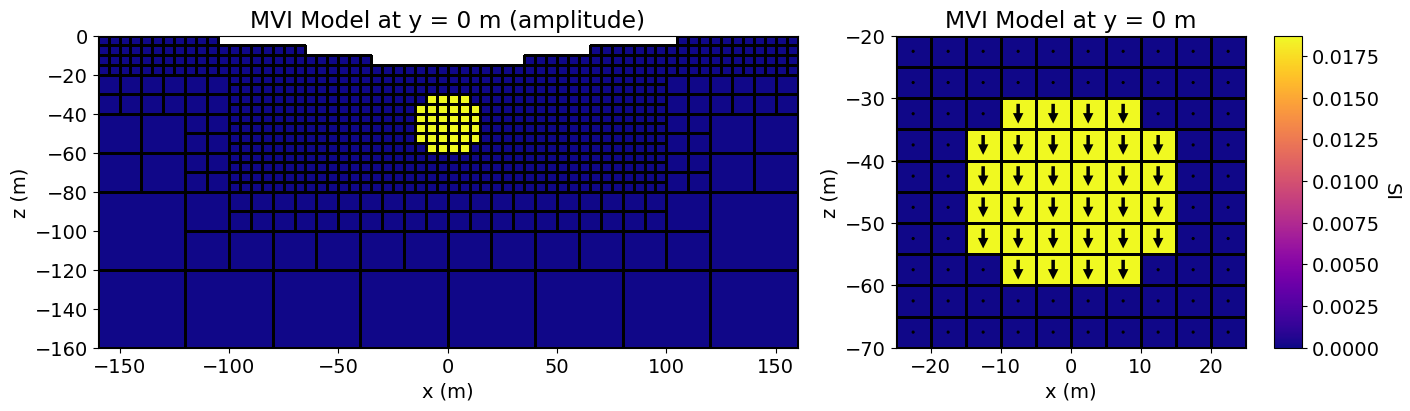

In [14]:
# Define effective susceptibility model as a vector np.r_[chi_x, chi_y, chi_z]
plotting_model = susceptibility_model + remanence_model
model = mkvc(plotting_model)

# Plot Effective Susceptibility Model
fig = plt.figure(figsize=(14, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
model_amplitude = np.sqrt(np.sum(plotting_model**2, axis=1))
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(model_amplitude))

ax1 = fig.add_axes([0.05, 0.12, 0.5, 0.78])
mesh.plot_slice(
    plotting_map * model_amplitude,
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm}
)
ax1.set_title("MVI Model at y = 0 m (amplitude)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.62, 0.12, 0.25, 0.78])
mesh.plot_slice(
    plotting_map * plotting_model,
    v_type="CCv",
    view="vec",
    normal="Y",
    ax=ax2,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
    quiver_opts={
        "pivot": "mid",
        "width": 0.01,
        "headwidth": 3.,
        "headlength": 3.,
        "headaxislength": 3.,
        "scale": 0.25
    },
)
ax2.set_title("MVI Model at y = 0 m")
ax2.set_xlim([-25, 25])
ax2.set_ylim([-70, -20])
ax2.set_xlabel("x (m)")
ax2.set_ylabel("z (m)")

cx = fig.add_axes([0.89, 0.12, 0.02, 0.78])
cbar = mpl.colorbar.ColorbarBase(
    cx, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("SI", rotation=270, labelpad=15)

## Defining the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class.
In this case, we use the simulation class for the [3D integral formulation](myst:SimPEG#SimPEG.potential_fields.magnetics.Simulation3DIntegral). To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the mesh
- the indices of the active cells
- the mapping from the model to the active cells
- the model type: "scalar" for susceptibility model, "vector" for magnetic vector model

This is accomplished by setting each one of the aforementioned items as a property of the simulation object. Additional keyword arguments can also be set which impact the forward simulation. Because we are only simulating data for a single model, there is no benefit to storing the sensitivities for the forward simulation. ``store_sensitivities`` property to *'forward_only'*

In [15]:
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="vector",
    chiMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only"
)

## Simulating Magnetic Graviometry Data

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](myst:SimPEG#SimPEG.simulation.BaseSimulation.dpred) method. In SimPEG, magnetic gradiometry data values are in **nT/m.**

In [16]:
dpred = simulation.dpred(model)

Data are ordered by component, then by location. Here, we reshape the predicted data vector into an array for easier plotting.

In [17]:
n_loc = survey.nRx         # Number of receiver locations
n_comp = len(components)   # Number of data components
dpred_plotting = np.reshape(dpred, (n_loc, n_comp))

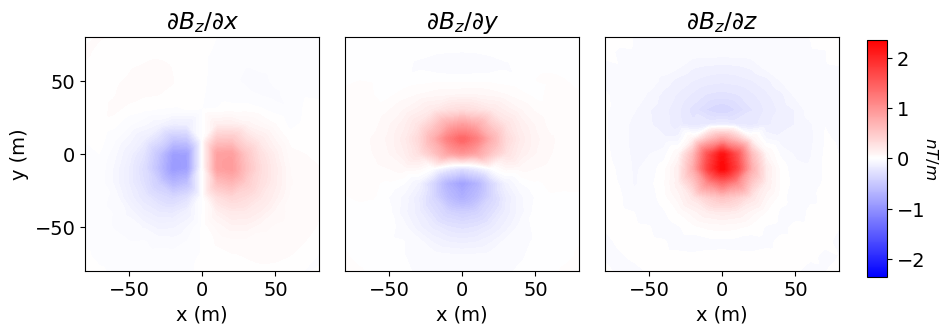

In [18]:
# Plot
fig = plt.figure(figsize=(10, 3))
v_max = np.max(np.abs(dpred))

ax = 3 * [None]
cplot = 3 * [None]
comp_list = ['x', 'y', 'z']

norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)

for ii in range(0, 3):
    ax[ii] = fig.add_axes([0.1+ii*0.26, 0.15, 0.25, 0.78])
    cplot[ii] = plot2Ddata(
        receiver_locations,
        dpred_plotting[:, ii],
        ax=ax[ii],
        ncontour=60,
        contourOpts={"cmap": "bwr", "norm": norm},
    )
    ax[ii].set_title(r"$\partial B_z /\partial {}$".format(comp_list[ii]))
    ax[ii].set_xlabel("x (m)")
    if ii == 0:
        ax[ii].set_ylabel("y (m)")
    else:
        ax[ii].set_yticks([])

cx = fig.add_axes([0.89, 0.13, 0.02, 0.79])
cbar = mpl.colorbar.ColorbarBase(
    cx, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT/m$", rotation=270, labelpad=10, size=12)

plt.show()